In [68]:
import pandas as pd
import numpy as np
# custom made functions (can be a pain to import sometimes)
import sys
sys.path.insert(0,os.path.abspath('../src/helper'))
from customPandas import *
#saving the model
import pickle
import random

## Loading the data

In [2]:
# https://stackoverflow.com/questions/39125532/file-does-not-exist-in-jupyter-notebook
dataPath = os.path.abspath('../data')
fileName = 'ramen-ratings.csv'
df = pd.read_csv(f'{dataPath}/{fileName}') 

## Cleaning some of the data

In [3]:
def cleanStars(value):
    if value == 'Unrated':
        return np.nan
    else:
        return value
df.Stars = df.Stars.apply(cleanStars) 
df[df.Stars == 'Unrated'].Stars

Series([], Name: Stars, dtype: object)

In [4]:
df = df.drop(['Review #','Top Ten'],axis=1)

In [5]:
df = df.fillna(method='ffill')

In [6]:
totalPercentageNullData(df)

,Total,Percent


In [7]:
# changing an incorrect dtype
df = df.astype({'Stars':'float64'})

In [8]:
df.describe()

,Stars
count,2580.000000
mean,3.654884
std,1.014886
min,0.000000
25%,3.250000
50%,3.750000
75%,4.250000
max,5.000000


In [9]:
Y = df['Stars']
df = df.drop(['Stars'],axis=1)

In [102]:
df[df['Brand'].isin(['Nongshim'])].head()

,Brand,Variety,Style,Country
12,Nongshim,Mr. Bibim Stir-Fried Kimchi Flavor,Pack,South Korea
47,Nongshim,Shin Ramyun Black,Pack,South Korea
57,Nongshim,Budae Jjigae Noodle Soup,Pack,South Korea
76,Nongshim,Shin Ramyun,Pack,South Korea
198,Nongshim,Seaweed Instant Noodle,Cup,South Korea


In [94]:
df.groupby(by=['Brand']).count()

,Variety,Style,Country
Brand,,,
1 To 3 Noodles,1,1,1
7 Select,2,2,2
7 Select/Nissin,1,1,1
A-One,4,4,4
A-Sha Dry Noodle,26,26,26
...,...,...,...
Yum Yum,12,12,12
Yum-Mie,1,1,1
Zow Zow,1,1,1


In [11]:
Y

0       3.75
1       1.00
2       2.25
3       2.75
4       3.75
        ... 
2575    3.50
2576    1.00
2577    2.00
2578    2.00
2579    0.50
Name: Stars, Length: 2580, dtype: float64

## Custom Transformers

In [12]:
from nltk.corpus import stopwords
import string
def nltkPreprocess(text):
    """
    Description:
        - Takes a text and cleans it by removing useless punctuations and stopwords
    input:
        -string
    output:
        - list of strings
    """
    # lower
    words = text.lower().split()
    # remove punctiuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    clean = [w for w in stripped if not w in stop_words if len(w)>2]
    return clean 


def cleanVariety(col):
    """
    description:
        - adaptation for 
    """
    cleanCol = list()
    # print(col)
    for v in col:
        # print(type(v))
        cleanCol.append(nltkPreprocess(v[0]))
    return col

In [13]:
# we are trying to make feature engineering part of our pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
#! because the way .fit works in sklearn it passes the arrays as np.array so you must specify
mapper = ColumnTransformer(transformers=[
('Variety', FunctionTransformer(cleanVariety, validate=False),[1])], remainder='passthrough')


## Pipeline

In [14]:
catFeats = df.dtypes[df.dtypes == 'object'].index.tolist()

def catFeat(df):
    return df[catFeats]

keepCat = FunctionTransformer(catFeat)

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('VarietyColNLPClean',mapper),
    ('ohc',OneHotEncoder(handle_unknown='ignore')),
    ('to_dense',ToDenseTransformer()),
    ('pca',PCA())
    ])

In [16]:
# very usefull pipeline visualization
from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('VarietyColNLPClean',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Variety',
                                                  FunctionTransformer(func=<function cleanVariety at 0x7fe509321310>),
                                                  [1])])),
                ('ohc', OneHotEncoder(handle_unknown='ignore')),
                ('to_dense',
                 <customPandas.ToDenseTransformer object at 0x7fe5008f6b50>),
                ('pca', PCA())])

## Hyperparameter tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
regressors = [BayesianRidge(),Lasso(), Ridge()]
# hyperparameter tuning for the Randomized Search
params = [{'regressors':[BayesianRidge()],
'regressors__n_iter' : [x for x in np.linspace(start=300,stop =1000,num=8)],
'regressors__alpha_1' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# 'pipeline__pca__n_components': [round(x) for x in np.linspace(start=3,stop = 100,num=8)]
},
{'regressors':[Lasso()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# preprocessing pipeline
# 'pipeline__pca__n_components': [round(x) for x in np.linspace(start=3,stop = 100,num=8)]
},

{'regressors':[Ridge()],
'regressors__alpha' : [round(x,2) for x in np.linspace(start=0.01,stop =1,num=8)],
# preprocessing pipeline
# 'pipeline__pca__n_components':[round(x) for x in np.linspace(start=3,stop = 100,num=8)]
}]
# if looking for specific parameters use the get_params methods (e.g.Lasso().get_params())

In [18]:
# preprocessor.get_params()

In [19]:
from sklearn.model_selection import train_test_split
# split of the datasla
X_train, X_test, y_train, y_test = train_test_split(df,Y,test_size=0.33, random_state=42)

In [20]:
baseModel = Pipeline([('categories', pipeline),
                      ('regressors', regressors[0])])
baseModel

Pipeline(steps=[('categories',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing',
                                                strategy='constant')),
                                 ('VarietyColNLPClean',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Variety',
                                                                   FunctionTransformer(func=<function cleanVariety at 0x7fe509321310>),
                                                                   [1])])),
                                 ('ohc',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('to_dense',
                                  <customPandas.ToDenseTransformer object at 0x7fe5008f6b50>),
                                 ('pca', PCA())])),
                ('regressors', BayesianRidge())])

In [21]:
pipeline['pca'].get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [22]:
tunedModel = RandomizedSearchCV(baseModel,params,verbose=1,n_iter=150, cv=5,random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


In [25]:
print("model score training data: %.3f" % tunedModel.score(X_train, y_train)) 
print("model score test data: %.3f" % tunedModel.score(X_test, y_test))
print(tunedModel.best_estimator_.get_params)
tunedModel.best_params_

model score training data: 0.836
model score test data: 0.235
<bound method Pipeline.get_params of Pipeline(steps=[('categories',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(fill_value='missing',
                                                strategy='constant')),
                                 ('VarietyColNLPClean',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Variety',
                                                                   FunctionTransformer(func=<function cleanVariety at 0x7fe509321310>),
                                                                   [1])])),
                                 ('ohc',
                                  OneHotEncoder(handle_unknown='ignore')),
                                 ('to_dense',
                                  <customPandas.ToDenseTransformer object at 0x7fe4ff9fe340>),
    

{'regressors__alpha': 1.0, 'regressors': Ridge()}

In [26]:
y_pred = tunedModel.predict(X_test)
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
mean_absolute_error(y_test,y_pred)

0.6350940579686039

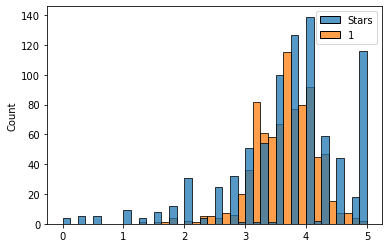

In [50]:
sns.histplot([y_test,y_pred]);

In [36]:
modelPath = os.path.abspath('../src/models/')
modelPath

'/home/henri/Documents/Post Lighthouse-Lab work/KaggleML/ramen-ratings/src/models'

In [44]:
# save the model to disk
filename = 'veryBasicModelMK1.sav'
pickle.dump(tunedModel, open(f'{modelPath}/{filename}', 'wb'))

In [46]:
# load the model from disk
loaded_model = pickle.load(open(f'{modelPath}/{filename}', 'rb'))

In [47]:
y_pred = loaded_model.predict(X_test)

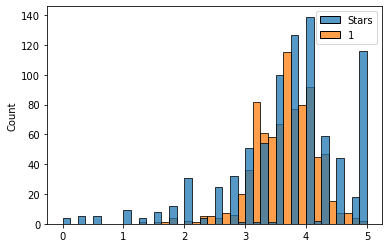

In [49]:
sns.histplot([y_test,y_pred]);

In [56]:
newRandoData ={ 
    'Brand':'Lee Fah Mee',
    'Variety':'Onion Soy sauce sour kimchi prawn',
    'Style':'cup',
    'Country': 'Japan'
}
newSeries = pd.Series(newRandoData)

In [88]:
def randomNoods():
    nood = [random.choice(df[i]) for i in df.columns.to_list()]
    print(nood)
    return nood

In [89]:
loaded_model.predict([newSeries])

array([3.82157079])

In [92]:
loaded_model.predict([randomNoods()])

['Hi-Myon', 'Scallion With Sichuan Pepper  Flavor', 'Tray', 'South Korea']


array([3.98707711])